In [7]:
import sys, importlib
#importlib.reload(sys.modules['utils'])

from utils import *

In [8]:
feature_balanced_dataset = pd.read_csv('data/cache/cached_features_balanced_dataset.pkl')
useful_ids = list(feature_balanced_dataset["footprint_id"])

In [9]:
# Load data
dataset_path = "data/postgis_output/"
cnn_dataset = load_and_preprocess_multiple_csv_from_path(dataset_path, \
                                                            preprocess_function=preprocess_cnn_dataset,\
                                                            dtype={'edifc_uso': object},\
                                                            filter_by_id=useful_ids,\
                                                            only_first_n=20)
cnn_balanced_dataset = balance_dataset(cnn_dataset, "edifc_uso_desc")

In [63]:
#TODO implement a "read_dataset_w_cache" function

#cnn_dataset.to_csv('data/cache/cached_cnn_dataset.pkl', index=False)
#cnn_balanced_dataset.to_csv('data/cache/cached_cnn_balanced_dataset.pkl', index=False)

#cnn_dataset = pd.read_csv('data/cache/cached_cnn_dataset.pkl')
cnn_balanced_dataset = pd.read_csv('data/cache/cached_cnn_balanced_dataset.pkl')

In [64]:
cnn_balanced_dataset.shape

(9080, 10002)

In [65]:
cnn_balanced_dataset

,footprint_id,edifc_uso_desc,0,1,2,3,4,5,6,7,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,50189.0,commerciale,160.17,160.17,160.17,160.17,160.17,160.17,160.17,160.17,...,160.17,160.17,160.17,160.17,160.17,160.17,160.17,160.17,160.17,160.17
1,16054.0,commerciale,174.11,174.11,174.11,174.11,174.11,174.11,174.11,174.11,...,174.11,174.11,174.11,174.11,174.11,174.11,174.11,174.11,174.11,174.11
2,2827.0,commerciale,175.03,175.03,175.03,175.03,175.03,175.03,175.03,175.03,...,175.03,175.03,175.03,175.03,175.03,175.03,175.03,175.03,175.03,175.03
3,39956.0,commerciale,145.21,145.21,145.21,145.21,145.21,145.21,145.21,145.21,...,145.21,145.21,145.21,145.21,145.21,145.21,145.21,145.21,145.21,145.21
4,34002.0,commerciale,159.48,159.48,159.48,159.48,159.48,159.48,159.48,159.48,...,159.48,159.48,159.48,159.48,159.48,159.48,159.48,159.48,159.48,159.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9075,72892.0,servizio pubblico,151.31,151.31,151.31,151.31,151.31,151.31,151.31,151.31,...,151.31,151.31,151.31,151.31,151.31,151.31,151.31,151.31,151.31,151.31
9076,56877.0,servizio pubblico,150.48,150.48,150.48,150.48,150.48,150.48,150.48,150.48,...,150.48,150.48,150.48,150.48,150.48,150.48,150.48,150.48,150.48,150.48
9077,15365.0,servizio pubblico,158.81,158.81,158.81,158.81,158.81,158.81,158.81,158.81,...,158.81,158.81,158.81,158.81,158.81,158.81,158.81,158.81,158.81,158.81
9078,58513.0,servizio pubblico,155.29,155.29,155.29,155.29,155.29,155.29,155.29,155.29,...,155.29,155.29,155.29,155.29,155.29,155.29,155.29,155.29,155.29,155.29


In [66]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [67]:
X_train = cnn_balanced_dataset.drop(labels = ["edifc_uso_desc", "footprint_id"],axis = 1) 
Y_train = cnn_balanced_dataset["edifc_uso_desc"]

# Normalize the data
normalization_factor = np.max(np.max(X_train))
X_train = X_train / normalization_factor

# Reshape image in 3 dimensions (height = 100px, width = 100px , canal = 1)
X_train = X_train.values.reshape(-1,100,100,1)

Y_train = pd.get_dummies(Y_train).values
num_classes = Y_train.shape[1]

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)

/Users/billy/Documents/university/dse/statistical_methods_for_machine_learning/MSA/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


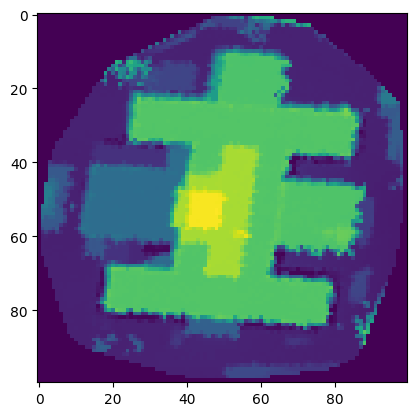

In [68]:
g = plt.imshow(X_train[2][:,:,0])

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau


# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (100,100,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

In [70]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"], run_eagerly=True)

In [71]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [76]:
epochs = 5
batch_size = 200

In [77]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [78]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
 5/40 [==>...........................] - ETA: 8:05 - loss: 1.3862 - accuracy: 0.2360

KeyboardInterrupt: 

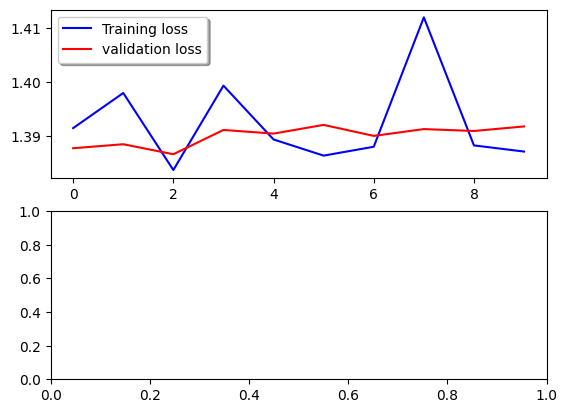

In [57]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

1/1 [==============================] - 0s 154ms/step


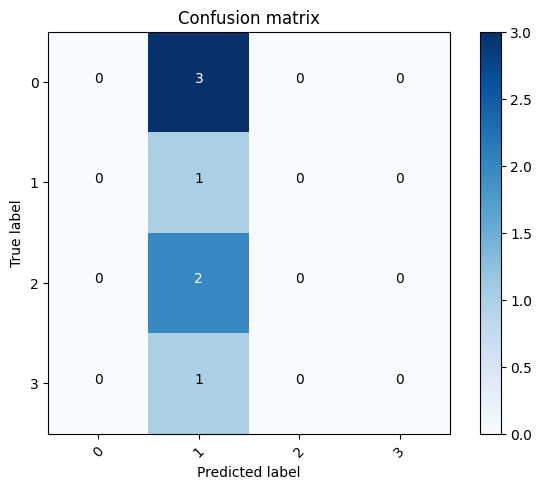

In [58]:
from sklearn.metrics import confusion_matrix
import itertools

# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes)) 

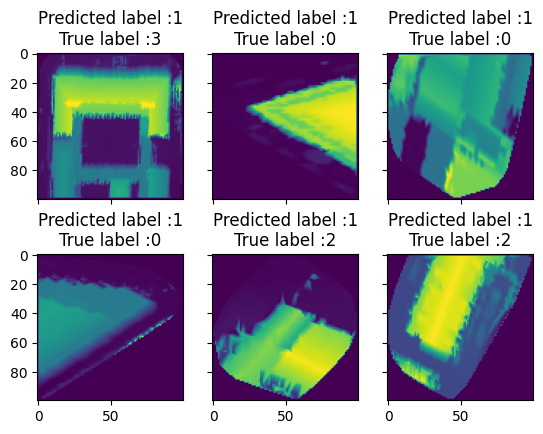

In [59]:
#Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((100,100)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)